# Plans for ML models using RDKit features

* Real danger of overfitting so could use regularisation 
* Could use feature importance to make quicker models

* Use FLAML to train models, 85:15 split as FLAML does cross-validation under-the-hood
* pIC50 = regression - exclude non-float compounds
* clearance_mouse, clearance_human = classification (multi-class) - therefore trees best shout
* logd - regression - WHAT IS BEST??
* PAMPA - classifcation (multi-class)

In [6]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('r_group_decomp.csv')

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

descriptors = {d[0]: d[1] for d in Descriptors.descList}   
rdkit_desc_dict = {}         
for i in df.index:
    mol = Chem.MolFromSmiles(df.at[i, "mol"])
    rdkit_desc_dict[i] = {d: descriptors[d](mol) for d in descriptors}

In [4]:
desc_df = pd.DataFrame.from_dict(rdkit_desc_dict)
desc_df = desc_df.T
# Drops any columns with zero variance and so useless for ML
to_drop = desc_df.columns[(desc_df.var() == 0)]
desc_df = desc_df.drop(to_drop, axis='columns')
desc_df.head()
# LGBM models struggle with column names so rename them using this line
desc_df = desc_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
desc_df.to_csv('r_group_rdkit_features.csv')

# pIC50 MODEL

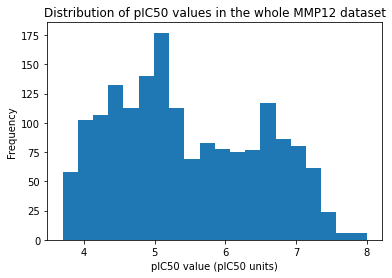

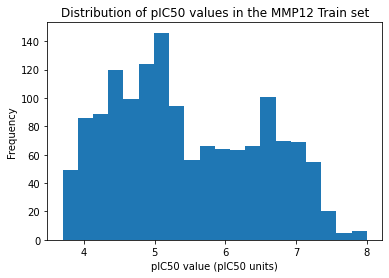

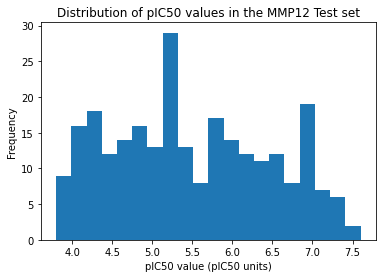

In [7]:
from sklearn.model_selection import train_test_split
desc_df = pd.read_csv('r_group_rdkit_features.csv', index_col=0)
df = pd.read_csv('r_group_decomp.csv')

df["pic50"] = pd.to_numeric(df['pic50'], errors='coerce')
true_labels = pd.to_numeric(df['pic50'], errors='coerce').dropna()
X_train, X_test, y_train, y_test = train_test_split(desc_df.loc[true_labels.index, :], true_labels , test_size=0.15, random_state=42)

plt.hist(true_labels, bins =20)
plt.title('Distribution of pIC50 values in the whole MMP12 dataset')
plt.xlabel('pIC50 value (pIC50 units)')
plt.ylabel('Frequency')
plt.show()

plt.hist(y_train, bins =20)
plt.title('Distribution of pIC50 values in the MMP12 Train set')
plt.xlabel('pIC50 value (pIC50 units)')
plt.ylabel('Frequency')
plt.show()

plt.hist(y_test, bins =20)
plt.title('Distribution of pIC50 values in the MMP12 Test set')
plt.xlabel('pIC50 value (pIC50 units)')
plt.ylabel('Frequency')
plt.show()





In [8]:
from flaml import AutoML
automl = AutoML()
automl.fit(
    X_train,
    y_train,
    task="regression",
    time_budget=420,
    estimator_list = [
        # 'lgbm',
        'xgboost',
        'xgb_limitdepth',
        # 'catboost',
        'rf',
        'extra_tree'
        ]
        )
with open("automl_pic50_model.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

[flaml.automl: 06-21 10:20:06] {2007} INFO - task = regression
[flaml.automl: 06-21 10:20:06] {2009} INFO - Data split method: uniform
[flaml.automl: 06-21 10:20:06] {2013} INFO - Evaluation method: cv
[flaml.automl: 06-21 10:20:06] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 06-21 10:20:06] {2170} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'rf', 'extra_tree']
[flaml.automl: 06-21 10:20:06] {2437} INFO - iteration 0, current learner xgboost
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

In [9]:
pic50_model = pickle.load(open('automl_pic50_model.pkl', 'rb'))
pred = pic50_model.predict(X_test)

R^2 = 0.70
MAE = 0.35 pIC50 units


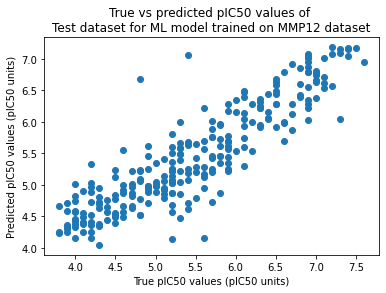

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
print(f'R^2 = {r2_score(pred, y_test.values):.2f}')
print(f'MAE = {mean_absolute_error(pred, y_test.values):.2f} pIC50 units')
plt.scatter(y_test.values, pred)
plt.title('''True vs predicted pIC50 values of 
Test dataset for ML model trained on MMP12 dataset''')
plt.xlabel('True pIC50 values (pIC50 units)')
plt.ylabel('Predicted pIC50 values (pIC50 units)')
plt.show()

# CLEARANCE MOUSE MODEL

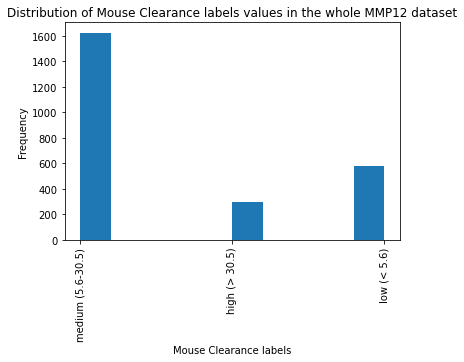

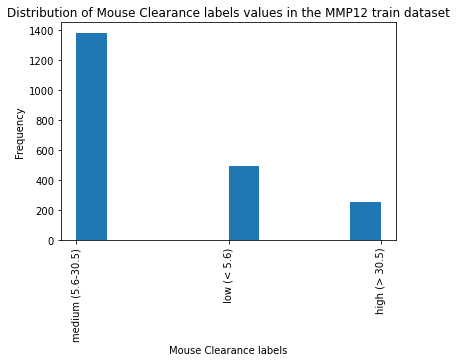

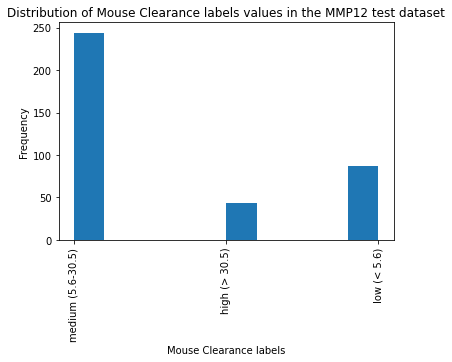

In [11]:
from sklearn.model_selection import train_test_split
desc_df = pd.read_csv('r_group_rdkit_features.csv', index_col=0)
df = pd.read_csv('r_group_decomp.csv')

plt.hist(df['clearance_mouse'],
#  bins=['low (< 3.7)','low (< 5.6)', 'poor', 'medium (5.6-30.5)', 'good', 'fair', 'high (> 30.5)']
 )
plt.title('Distribution of Mouse Clearance labels values in the whole MMP12 dataset')
plt.xlabel('Mouse Clearance labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

# Drop single compound that has low (< 3.7) as stops scoring and stratified splitting
df_cleaned = df[df['clearance_mouse']!='low (< 3.7)']
X_train, X_test, y_train, y_test = train_test_split(desc_df.loc[df_cleaned.index, :], df_cleaned['clearance_mouse'], test_size=0.15, stratify=df_cleaned['clearance_mouse'], random_state=42)

plt.hist(y_train)
plt.title('Distribution of Mouse Clearance labels values in the MMP12 train dataset')
plt.xlabel('Mouse Clearance labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

plt.hist(y_test)
plt.title('Distribution of Mouse Clearance labels values in the MMP12 test dataset')
plt.xlabel('Mouse Clearance labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()


In [12]:
from flaml import AutoML
automl = AutoML()
automl.fit(
    X_train,
    y_train,
    task="classification",
    time_budget=420,
    estimator_list = [
        # 'lgbm',
        'xgboost',
        'xgb_limitdepth',
        # 'catboost',
        'rf',
        'extra_tree'
        ])
with open("automl_clearance_mouse_model.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

[flaml.automl: 06-21 10:27:19] {2007} INFO - task = classification
[flaml.automl: 06-21 10:27:19] {2009} INFO - Data split method: stratified
[flaml.automl: 06-21 10:27:19] {2013} INFO - Evaluation method: cv
[flaml.automl: 06-21 10:27:19] {2113} INFO - Minimizing error metric: log_loss
[flaml.automl: 06-21 10:27:19] {2170} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'rf', 'extra_tree']
[flaml.automl: 06-21 10:27:19] {2437} INFO - iteration 0, current learner xgboost
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropria

In [13]:
c_mouse_model = pickle.load(open('automl_clearance_mouse_model.pkl', 'rb'))
pred = c_mouse_model.predict(X_test)
pred_probs = c_mouse_model.predict_proba(X_test)

/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


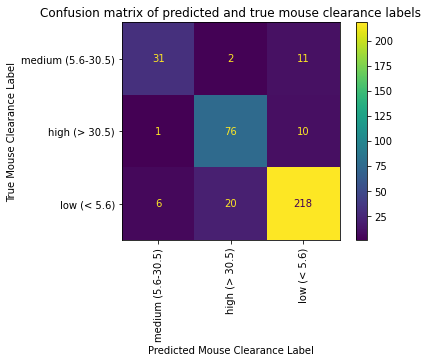

AUROC = 0.959
F1 = 0.867
MCC = 0.741


In [14]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, f1_score, matthews_corrcoef
disp = plot_confusion_matrix(c_mouse_model, X_test, y_test,
                                 display_labels=set(y_test))
plt.xticks(rotation = 90) 
plt.title('Confusion matrix of predicted and true mouse clearance labels')
plt.ylabel('True Mouse Clearance Label')
plt.xlabel('Predicted Mouse Clearance Label')
plt.show()
roc_auc_score_value = roc_auc_score(
    y_test, pred_probs, multi_class="ovr", average="weighted"
  )
f1_score_value = f1_score(y_test, pred, average="weighted")
mcc_value = matthews_corrcoef(y_test, pred)
print(f'AUROC = {roc_auc_score_value:.3f}')
print(f'F1 = {f1_score_value:.3f}')
print(f'MCC = {mcc_value:.3f}')

# CLEARANCE HUMAN MODEL

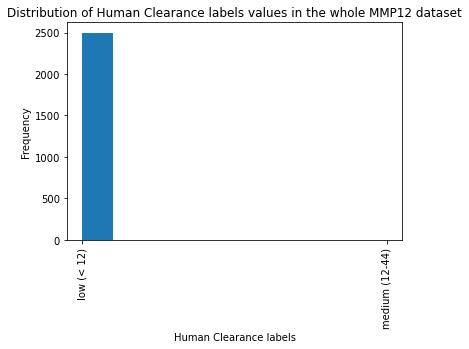

2499


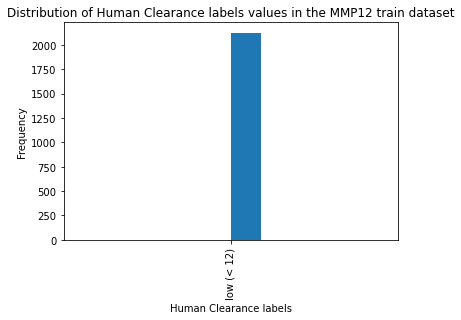

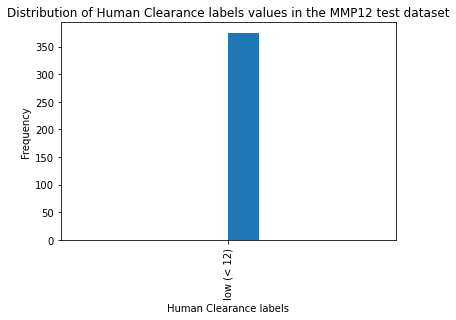

In [17]:
from sklearn.model_selection import train_test_split
desc_df = pd.read_csv('r_group_rdkit_features.csv', index_col=0)
df = pd.read_csv('r_group_decomp.csv')

plt.hist(df['clearance_human'],
#  bins=['low (< 3.7)','low (< 5.6)', 'poor', 'medium (5.6-30.5)', 'good', 'fair', 'high (> 30.5)']
 )
plt.title('Distribution of Human Clearance labels values in the whole MMP12 dataset')
plt.xlabel('Human Clearance labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

# Both of these medium classes only have 1 molecule each
# df_cleaned = df[df['clearance_human']!='medium (5.6-30.5)']
# df_cleaned = df_cleaned[df_cleaned['clearance_human']!='medium (12-44)']
print(len(df_cleaned))
X_train, X_test, y_train, y_test = train_test_split(desc_df.loc[df_cleaned.index, :], df_cleaned['clearance_human'], test_size=0.15, stratify=df_cleaned['clearance_human'], random_state=42)

plt.hist(y_train)
plt.title('Distribution of Human Clearance labels values in the MMP12 train dataset')
plt.xlabel('Human Clearance labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

plt.hist(y_test)
plt.title('Distribution of Human Clearance labels values in the MMP12 test dataset')
plt.xlabel('Human Clearance labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

In [39]:
# from flaml import AutoML
# automl = AutoML()
# automl.fit(
#     X_train,
#     y_train,
#     task="classification",
#     time_budget=420,
#     estimator_list = [
#         # 'lgbm',
#         'xgboost',
#         'xgb_limitdepth',
#         # 'catboost',
#         'rf',
#         'extra_tree'
#         ])
# with open("automl_clearance_human_model.pkl", "wb") as f:
#     pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

'''
No point having a ML model as only one class to predict
'''

'\nNo point having a ML model as only one class to predict\n'

In [40]:
# c_human_model = pickle.load(open('automl_clearance_human_model.pkl', 'rb'))
# pred = c_human_model.predict(X_test)
# pred_probs = c_human_model.predict_proba(X_test)

In [41]:
# from sklearn.metrics import plot_confusion_matrix, roc_auc_score, f1_score, matthews_corrcoef
# disp = plot_confusion_matrix(c_human_model, X_test, y_test,
#                                  display_labels=set(y_test))
# plt.xticks(rotation = 90) 
# plt.title('Confusion matrix of predicted and true human clearance labels')
# plt.ylabel('True Human Clearance Label')
# plt.xlabel('Predicted Human Clearance Label')
# plt.show()
# roc_auc_score_value = roc_auc_score(
#     y_test, pred_probs, multi_class="ovr", average="weighted"
#   )
# f1_score_value = f1_score(y_test, pred, average="weighted")
# mcc_value = matthews_corrcoef(y_test, pred)
# print(f'AUROC = {roc_auc_score_value:.3f}')
# print(f'F1 = {f1_score_value:.3f}')
# print(f'MCC = {mcc_value:.3f}')

# PAMPA MODEL

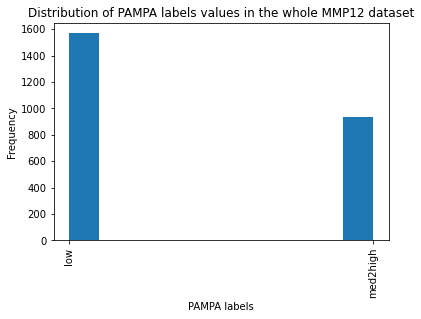

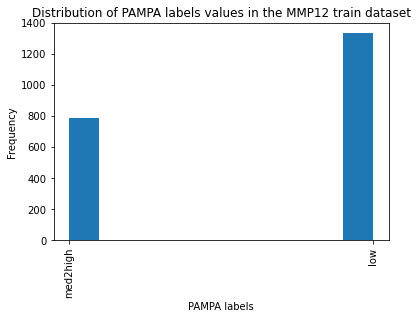

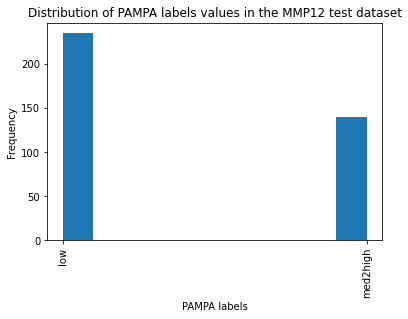

In [18]:
from sklearn.model_selection import train_test_split
desc_df = pd.read_csv('r_group_rdkit_features.csv', index_col=0)
df = pd.read_csv('r_group_decomp.csv')

plt.hist(df['pampa'],
#  bins=['low (< 3.7)','low (< 5.6)', 'poor', 'medium (5.6-30.5)', 'good', 'fair', 'high (> 30.5)']
 )
plt.title('Distribution of PAMPA labels values in the whole MMP12 dataset')
plt.xlabel('PAMPA labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

# Drop single compound that has 'neg' as stops scoring and stratified splitting
df_cleaned = df[df['pampa']!='neg']
X_train, X_test, y_train, y_test = train_test_split(desc_df.loc[df_cleaned.index, :], df_cleaned['pampa'], test_size=0.15, stratify=df_cleaned['pampa'], random_state=42)

plt.hist(y_train)
plt.title('Distribution of PAMPA labels values in the MMP12 train dataset')
plt.xlabel('PAMPA labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

plt.hist(y_test)
plt.title('Distribution of PAMPA labels values in the MMP12 test dataset')
plt.xlabel('PAMPA labels')
plt.xticks(rotation = 90) 
plt.ylabel('Frequency')
plt.show()

In [19]:
from flaml import AutoML
automl = AutoML()
automl.fit(
    X_train,
    y_train,
    task="classification",
    time_budget=420,
    estimator_list = [
        # 'lgbm',
        'xgboost',
        'xgb_limitdepth',
        # 'catboost',
        'rf',
        'extra_tree'
        ])
with open("automl_pampa_model.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

[flaml.automl: 06-21 10:47:14] {2007} INFO - task = classification
[flaml.automl: 06-21 10:47:14] {2009} INFO - Data split method: stratified
[flaml.automl: 06-21 10:47:14] {2013} INFO - Evaluation method: cv
[flaml.automl: 06-21 10:47:14] {2113} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 06-21 10:47:14] {2170} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'rf', 'extra_tree']
[flaml.automl: 06-21 10:47:14] {2437} INFO - iteration 0, current learner xgboost
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

In [20]:
pampa_model = pickle.load(open('automl_pampa_model.pkl', 'rb'))
pred = pampa_model.predict(X_test)
pred_probs = pampa_model.predict_proba(X_test)

/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [29]:
print(y_test)

339          low
1484    med2high
1495    med2high
2280         low
97      med2high
          ...   
367     med2high
743          low
1920    med2high
1194         low
458          low
Name: pampa, Length: 375, dtype: object


/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


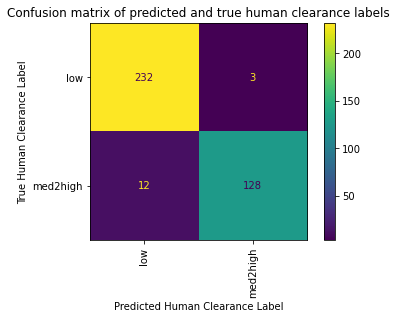

AUROC = 0.995
F1 = 0.960
MCC = 0.915


In [34]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, f1_score, matthews_corrcoef
disp = plot_confusion_matrix(pampa_model, X_test, y_test,
                                 display_labels=set(y_test))
plt.xticks(rotation = 90) 
plt.title('Confusion matrix of predicted and true human clearance labels')
plt.ylabel('True Human Clearance Label')
plt.xlabel('Predicted Human Clearance Label')
plt.show()
roc_auc_score_value = roc_auc_score(
    y_test, pred_probs[:, 1]
  )
f1_score_value = f1_score(y_test, pred, average='weighted')
mcc_value = matthews_corrcoef(y_test, pred)
print(f'AUROC = {roc_auc_score_value:.3f}')
print(f'F1 = {f1_score_value:.3f}')
print(f'MCC = {mcc_value:.3f}')


# LogD MODEL

2500


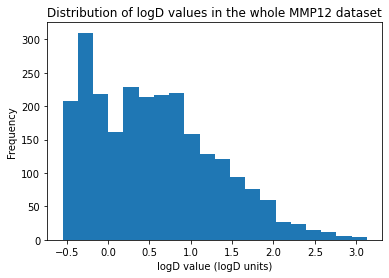

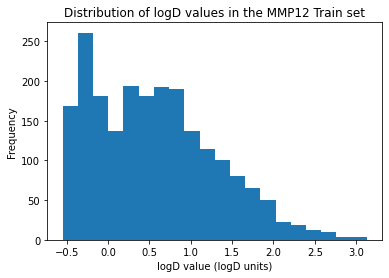

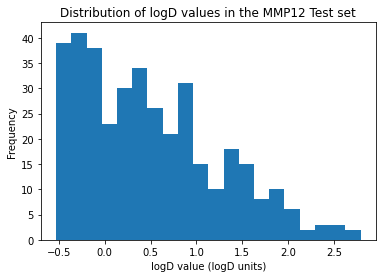

In [35]:
from sklearn.model_selection import train_test_split
desc_df = pd.read_csv('r_group_rdkit_features.csv', index_col=0)
df = pd.read_csv('r_group_decomp.csv')

df["logd"] = pd.to_numeric(df['logd'], errors='coerce')
true_labels = pd.to_numeric(df['logd'], errors='coerce').dropna()
print(len(true_labels))
X_train, X_test, y_train, y_test = train_test_split(desc_df.loc[true_labels.index, :], true_labels , test_size=0.15, random_state=42)

plt.hist(true_labels, bins =20)
plt.title('Distribution of logD values in the whole MMP12 dataset')
plt.xlabel('logD value (logD units)')
plt.ylabel('Frequency')
plt.show()

plt.hist(y_train, bins =20)
plt.title('Distribution of logD values in the MMP12 Train set')
plt.xlabel('logD value (logD units)')
plt.ylabel('Frequency')
plt.show()

plt.hist(y_test, bins =20)
plt.title('Distribution of logD values in the MMP12 Test set')
plt.xlabel('logD value (logD units)')
plt.ylabel('Frequency')
plt.show()


In [36]:
from flaml import AutoML
automl = AutoML()
automl.fit(
    X_train,
    y_train,
    task="regression",
    time_budget=420,
    estimator_list = [
        # 'lgbm',
        'xgboost',
        'xgb_limitdepth',
        # 'catboost',
        'rf',
        'extra_tree'
        ]
        )
with open("automl_logd_model.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

[flaml.automl: 06-21 11:28:55] {2007} INFO - task = regression
[flaml.automl: 06-21 11:28:55] {2009} INFO - Data split method: uniform
[flaml.automl: 06-21 11:28:55] {2013} INFO - Evaluation method: cv
[flaml.automl: 06-21 11:28:55] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 06-21 11:28:55] {2170} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'rf', 'extra_tree']
[flaml.automl: 06-21 11:28:55] {2437} INFO - iteration 0, current learner xgboost
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/guy/miniconda3/envs/dd_game/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype in

In [37]:
logd_model = pickle.load(open('automl_logd_model.pkl', 'rb'))
pred = logd_model.predict(X_test)

R^2 = 0.99
Pearson's R = 0.99
MAE = 0.06 logD units


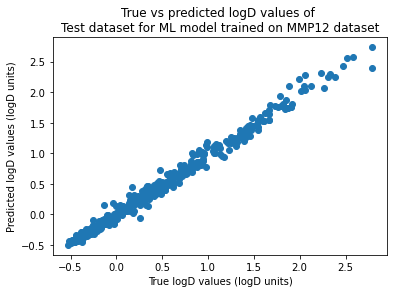

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
print(f'R^2 = {r2_score(pred, y_test.values):.2f}')
print(f"Pearson's R = {pearsonr(pred, y_test.values)[0]:.2f}")
print(f'MAE = {mean_absolute_error(pred, y_test.values):.2f} logD units')
plt.scatter(y_test.values, pred)
plt.title('''True vs predicted logD values of 
Test dataset for ML model trained on MMP12 dataset''')
plt.xlabel('True logD values (logD units)')
plt.ylabel('Predicted logD values (logD units)')
plt.show()